In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 32
learning_rate  = 1e-2
momentum = 0.5
epochs = 100
patience = 7

In [3]:
train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transforms.Compose([
                                transforms.Resize([256, 256]),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),                       # 数据类型转化
                                transforms.Normalize(
                                    (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # 数据归一化处理
                            ]))

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                           ]))

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
train_loader = torch.utils.data.DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False
)

In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, relu=True, **kwargs):
        super(BasicConv2d, self).__init__()
        self.relu = relu
        if self.relu:
            self.features = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
            )

    def forward(self, x):
        out = self.features(x)
        return out

In [8]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.feature = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        out = self.avgpool(x)
        out = out.view(x.size(0), -1)
        out = self.feature(out)
        out = out.view(x.size(0), x.size(1), 1, 1)
        return x * out.expand_as(x)


In [9]:
class SEBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(SEBasicBlock, self).__init__()
        self.features = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=out_channels,
                        relu=True, kernel_size=3, stride=stride, padding=1, bias=False),
            BasicConv2d(in_channels=out_channels, out_channels=out_channels,
                        relu=False, kernel_size=3, stride=1, padding=1, bias=False),
            SEBlock(in_channels=out_channels),

        )
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        if self.downsample is None:
            residual = x
        else:
            residual = self.downsample(x)
        out = self.features(x)
        out += residual
        out = F.relu(out, inplace=True)

        return out

In [10]:
class SEBottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(SEBottleneck, self).__init__()
        self.features = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=out_channels,
                        relu=False, kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=out_channels, out_channels=out_channels,
                        relu=False, kernel_size=3, stride=stride, padding=1, bias=False),
            BasicConv2d(in_channels=out_channels, out_channels=out_channels *
                        self.expansion, relu=True, kernel_size=1, stride=1, padding=0, bias=False),
            SEBlock(in_channels=out_channels),
            
        )
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        if self.downsample is None:
            residual = x
        else:
            residual = self.downsample(x)
        out = self.features(x)
        out += residual
        out = F.relu(out, inplace=True)

        return out

In [11]:
class SEResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(SEResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            BasicConv2d(in_channels=3, out_channels=64, relu=True,
                        kernel_size=7, stride=2, padding=3, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.layer1 = self._make_layer(
            block=block, out_channels=64, num_blocks=layers[0], stride=1)
        self.layer2 = self._make_layer(
            block=block, out_channels=128, num_blocks=layers[1], stride=2)
        self.layer3 = self._make_layer(
            block=block, out_channels=256, num_blocks=layers[2], stride=2)
        self.layer4 = self._make_layer(
            block=block, out_channels=512, num_blocks=layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = BasicConv2d(in_channels=self.in_channels, out_channels=out_channels * block.expansion, relu=False,
                                     kernel_size=1, stride=stride, bias=False)
        layers = []
        layers.append(block(in_channels=self.in_channels,
                            out_channels=out_channels, stride=stride, downsample=downsample))
        self.in_channels = out_channels * block.expansion
        for i in range(1, num_blocks):
            layers.append(block(in_channels=self.in_channels,
                                out_channels=out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [12]:
def SEresnet18(**kwargs):
    model = SEResNet(SEBasicBlock, [2, 2, 2, 2], **kwargs)
    return model


def SEresnet34(**kwargs):
    model = SEResNet(SEBasicBlock, [3, 4, 6, 3], **kwargs)
    return model


def SEresnet50(**kwargs):
    model = SEResNet(SEBottleneck, [3, 4, 6, 3], **kwargs)
    return model


def SEresnet101(**kwargs):
    model = SEResNet(SEBottleneck, [3, 4, 23, 3], **kwargs)
    return model


def SEresnet152(**kwargs):
    model = SEResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

In [13]:
net = SEresnet18().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
       BasicConv2d-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
       BasicConv2d-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BasicConv2d-12           [-1, 64, 56, 56]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
           Linear-14                   

In [16]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()
        
        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(val_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [17]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))
    
    return val_loss, val_acc

In [18]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [19]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [20]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))
    
    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)
    
    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')
    
    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [21]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)
        
        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)
    
    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.450639
Train Epoch: 1 [3200/40000 (8%)]	Loss: 1.601285
Train Epoch: 1 [6400/40000 (16%)]	Loss: 1.557768
Train Epoch: 1 [9600/40000 (24%)]	Loss: 1.700126
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.713022
Train Epoch: 1 [16000/40000 (40%)]	Loss: 1.419556
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.472512
Train Epoch: 1 [22400/40000 (56%)]	Loss: 1.587565
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.915553
Train Epoch: 1 [28800/40000 (72%)]	Loss: 1.735991
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.313355
Train Epoch: 1 [35200/40000 (88%)]	Loss: 1.467150
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.294845
VAL set: Average loss: 0.044808, Accuracy: 4898.0/10000 (49.0%)
Validation loss decreased (inf --> 0.044808).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.488745
Train Epoch: 2 [3200/40000 (8%)]	Loss: 1.436758
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.225011
Train Epoch: 2 [9600/40000 (24%)]	Loss: 1.411067
Train Epoch: 2 [12800/40000 (32%)]	Loss

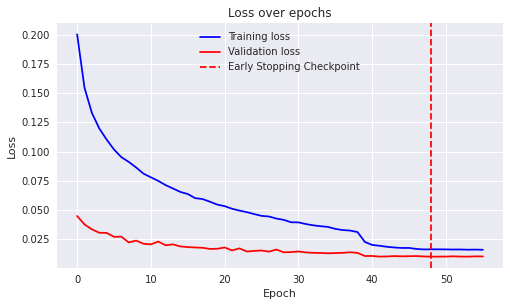

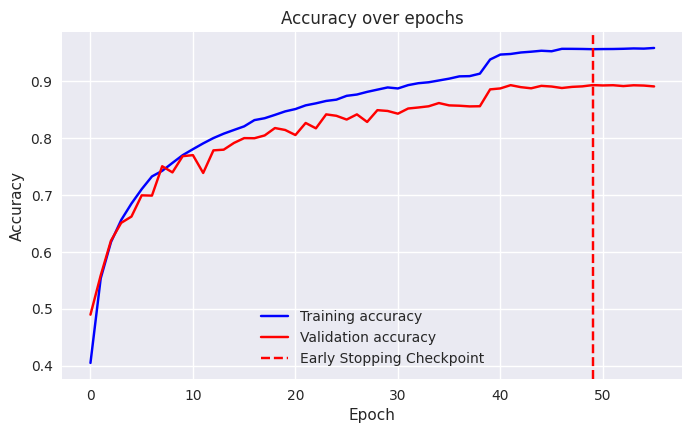

In [22]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'SEResNet-18 - predictions')

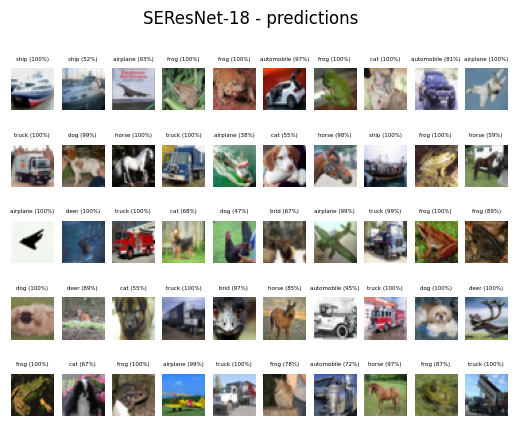

In [23]:
CIFAR_dict = {0: 'airplane',
              1: 'automobile',
              2: 'brid',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[int(torch.argmax(probs))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('SEResNet-18 - predictions')

In [ ]:
"""
MobileNetV1
Mine(batch_size = 32):
After 20 Epoch: 76.2%
After 40 Epoch: 83.1%
After 60 Epoch: 85.5%
After 80 Epoch: 87.3%
After 80 Epoch: 87.3%
structure:
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 1024, 1, 1]          --
|    └─BasicConv2d: 2-1                  [-1, 32, 111, 111]        --
|    |    └─Sequential: 3-1              [-1, 32, 111, 111]        960
|    └─DWConv2d: 2-2                     [-1, 64, 111, 111]        --
|    |    └─Sequential: 3-2              [-1, 64, 111, 111]        11,456
|    └─DWConv2d: 2-3                     [-1, 128, 56, 56]         --
|    |    └─Sequential: 3-3              [-1, 128, 56, 56]         45,440
|    └─DWConv2d: 2-4                     [-1, 128, 56, 56]         --
|    |    └─Sequential: 3-4              [-1, 128, 56, 56]         164,352
|    └─DWConv2d: 2-5                     [-1, 256, 28, 28]         --
|    |    └─Sequential: 3-5              [-1, 256, 28, 28]         180,992
|    └─DWConv2d: 2-6                     [-1, 256, 28, 28]         --
|    |    └─Sequential: 3-6              [-1, 256, 28, 28]         656,384
|    └─DWConv2d: 2-7                     [-1, 512, 14, 14]         --
|    |    └─Sequential: 3-7              [-1, 512, 14, 14]         722,432
|    └─DWConv2d: 2-8                     [-1, 512, 14, 14]         --
|    |    └─Sequential: 3-8              [-1, 512, 14, 14]         2,623,488
|    └─DWConv2d: 2-9                     [-1, 512, 14, 14]         --
|    |    └─Sequential: 3-9              [-1, 512, 14, 14]         2,623,488
|    └─DWConv2d: 2-10                    [-1, 512, 14, 14]         --
|    |    └─Sequential: 3-10             [-1, 512, 14, 14]         2,623,488
|    └─DWConv2d: 2-11                    [-1, 512, 14, 14]         --
|    |    └─Sequential: 3-11             [-1, 512, 14, 14]         2,623,488
|    └─DWConv2d: 2-12                    [-1, 512, 14, 14]         --
|    |    └─Sequential: 3-12             [-1, 512, 14, 14]         2,623,488
|    └─DWConv2d: 2-13                    [-1, 1024, 7, 7]          --
|    |    └─Sequential: 3-13             [-1, 1024, 7, 7]          2,886,656
|    └─DWConv2d: 2-14                    [-1, 1024, 7, 7]          --
|    |    └─Sequential: 3-14             [-1, 1024, 7, 7]          10,489,856
|    └─AvgPool2d: 2-15                   [-1, 1024, 1, 1]          --
├─Linear: 1-2                            [-1, 1000]                1,025,000
==========================================================================================
Total params: 29,300,968
Trainable params: 29,300,968
Non-trainable params: 0
Total mult-adds (M): 124.73
==========================================================================================
Input size (MB): 0.57
Forward/backward pass size (MB): 6.02
Params size (MB): 111.77
Estimated Total Size (MB): 118.37
==========================================================================================
parameters_count: 29300968
"""